### Import Packages

In [1]:
# Import packages
import pandas as pd

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from math import sqrt

import pickle

### Load Data

In [2]:
# Load the data (assuming the same dataset and structure as previously discussed)
df = pd.read_excel("./data/Folds5x2_pp.xlsx")

### Data Cleaning

#### Duplicates check and clean up

In [3]:
# Check for duplicates
df.duplicated().sum()

41

In [4]:
# Remove duplicates to prevent data leakage
df.drop_duplicates(inplace=True)

### Exploratory Data Analysis

#### Dataset characteristics

In [5]:
# Shape of the dataset
df.shape

(9527, 5)

In [6]:
# Check basic info on dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9527 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9527 non-null   float64
 1   V       9527 non-null   float64
 2   AP      9527 non-null   float64
 3   RH      9527 non-null   float64
 4   PE      9527 non-null   float64
dtypes: float64(5)
memory usage: 446.6 KB


In [7]:
# Check for missing values
df.isna().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

In [8]:
# Check variable value ranges and basic stats
df.describe()

,AT,V,AP,RH,PE
count,9527.000000,9527.000000,9527.000000,9527.000000,9527.00000
mean,19.658225,54.293421,1013.237084,73.334951,454.33591
std,7.444397,12.686309,5.940526,14.607513,17.03908
min,1.810000,25.360000,992.890000,25.560000,420.26000
25%,13.530000,41.740000,1009.085000,63.375000,439.75000
50%,20.350000,52.080000,1012.920000,75.000000,451.52000
75%,25.710000,66.510000,1017.200000,84.850000,468.36500
max,37.110000,81.560000,1033.300000,100.160000,495.76000


In [9]:
# Sanity check on RH for values over 100%
print(f"Percentage over 100% RH: {len(df[df['RH']>100])/len(df) * 100:.2f}%")
print(f"No. of observations: {len(df[df['RH']>100])}")

Percentage over 100% RH: 0.58%
No. of observations: 55


The dataset consists of 5 float variables, of which four are features and one is the target. The four features are, AT (Ambient Temperature, °C), V (Vaccum, cm Hg), AP (Atmospheric Pressure, mbar) and RH (Relative Humidity, %) while the target is PE (Full Load Electrical Power Output, MW). There are no missing values and the values are in typical sane ranges. There are 55 instances of RH exceeding 100%, with the highest value at 100.16%. Given that they are barely over 100%, they can be considered to be within the margin of error typically associated with measurement inaccuracies.

#### Correlation  from pair plot and correlation matrix

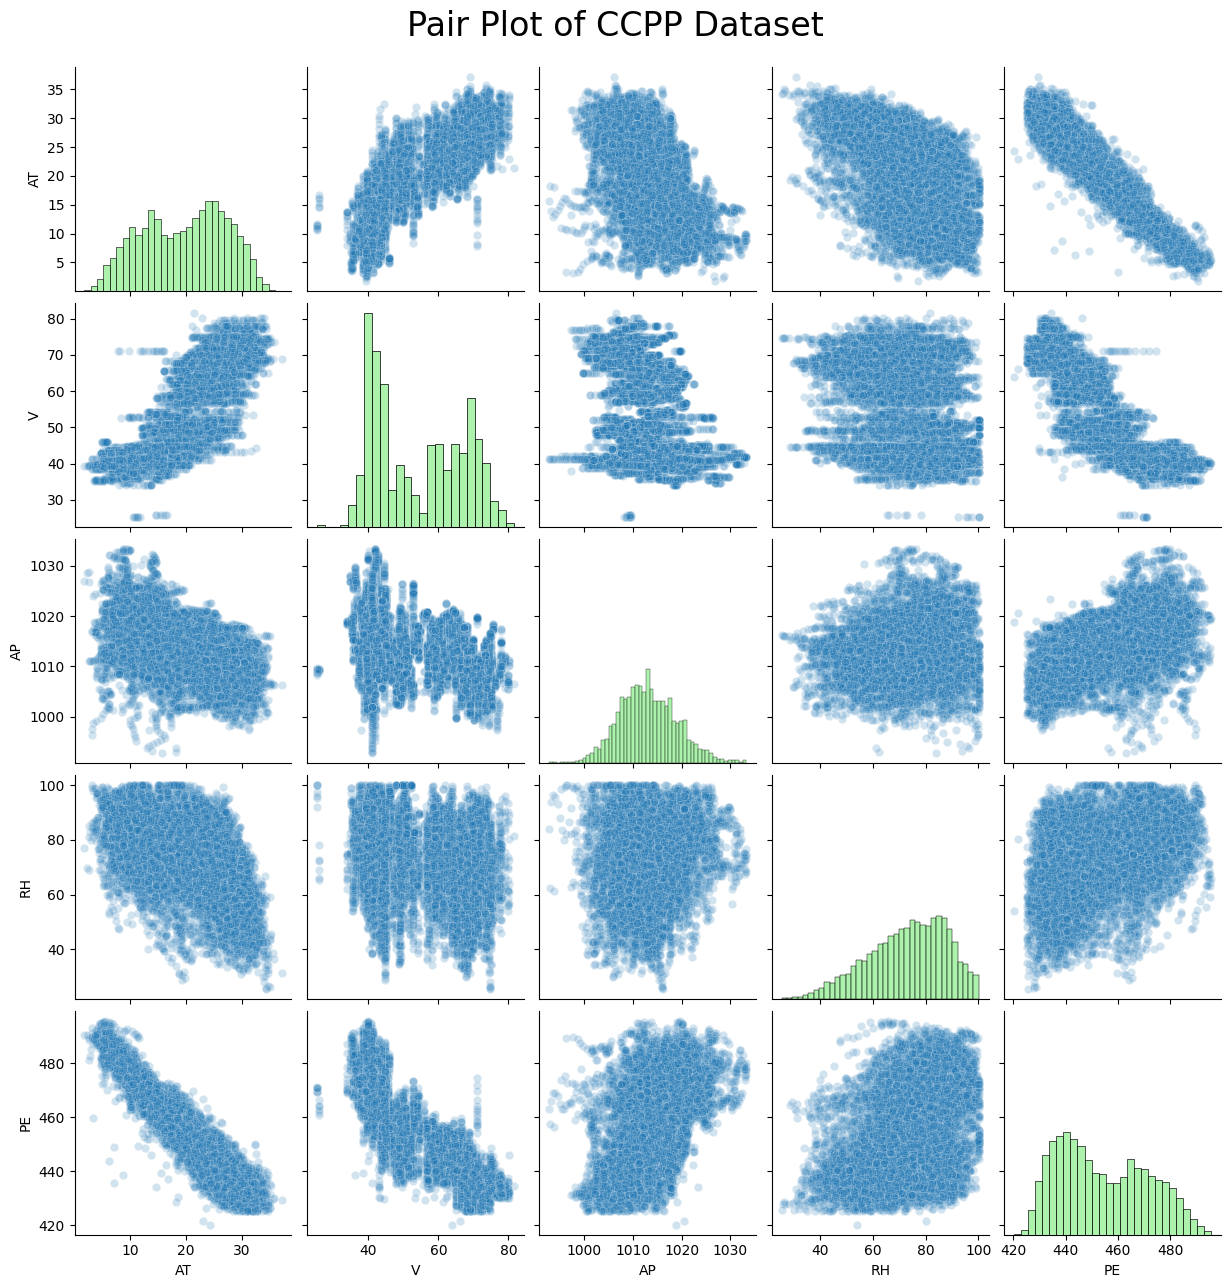

In [10]:
# Pair plot for the dataset
sns.pairplot(df, plot_kws={'alpha': 0.2}, diag_kws={'color': 'lightgreen'})
plt.suptitle("Pair Plot of CCPP Dataset", fontsize=24, y=1.03)
plt.show()

The pair plot of the variables suggests strong correlation between AT and PE, also between V and PE, and some correlation between AP and PE. Between the feature variables, AT and V appear highly correlated. A correlation matrix can confirm this.

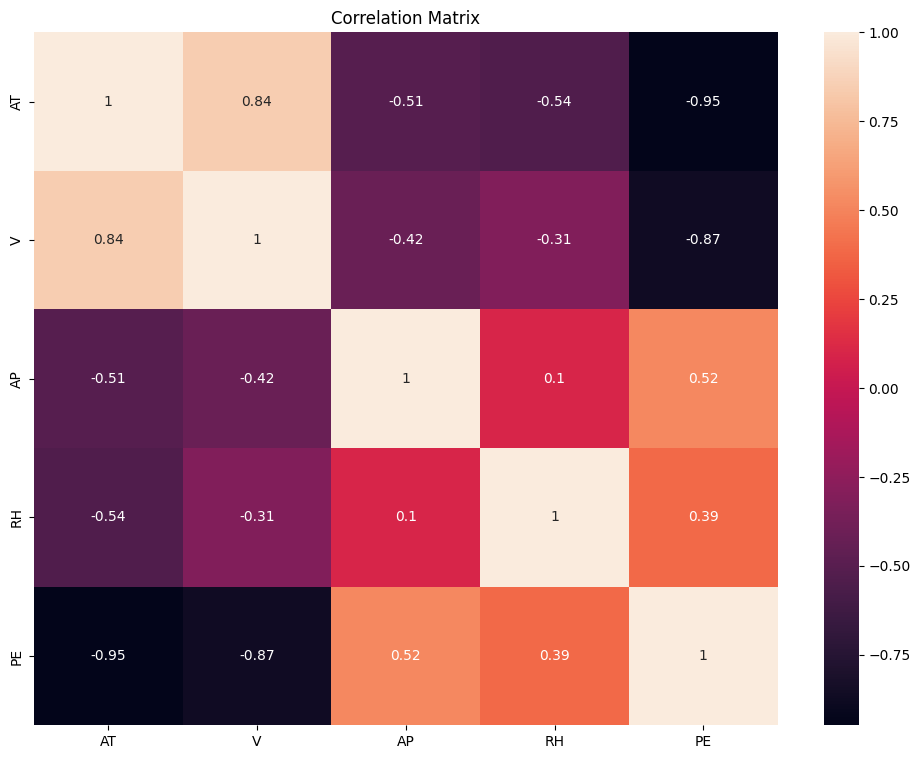

In [11]:
# Visualize a correlation matrix of the dataset
plt.figure(figsize=(12, 9))
sns.heatmap(df.corr(), annot=True)
plt.title("Correlation Matrix")
plt.show()

The correlation matrix aligns with insights gained from the pair plot, highlighting a strong correlation between AT and V, and comparatively weaker correlations between AT and RH, as well as AT and AP. This suggests multicollinearity in the data. To address this, Principal Component Analysis (PCA) will be employed where appropriate, to map the features onto orthogonal principal components which provide non-redundant representation of the variance in the data. The optimal number of PCA components will be determined through creating a scree plot to analyse the proportion of variance explained by each component.

#### Data distribution from histogram and boxplot

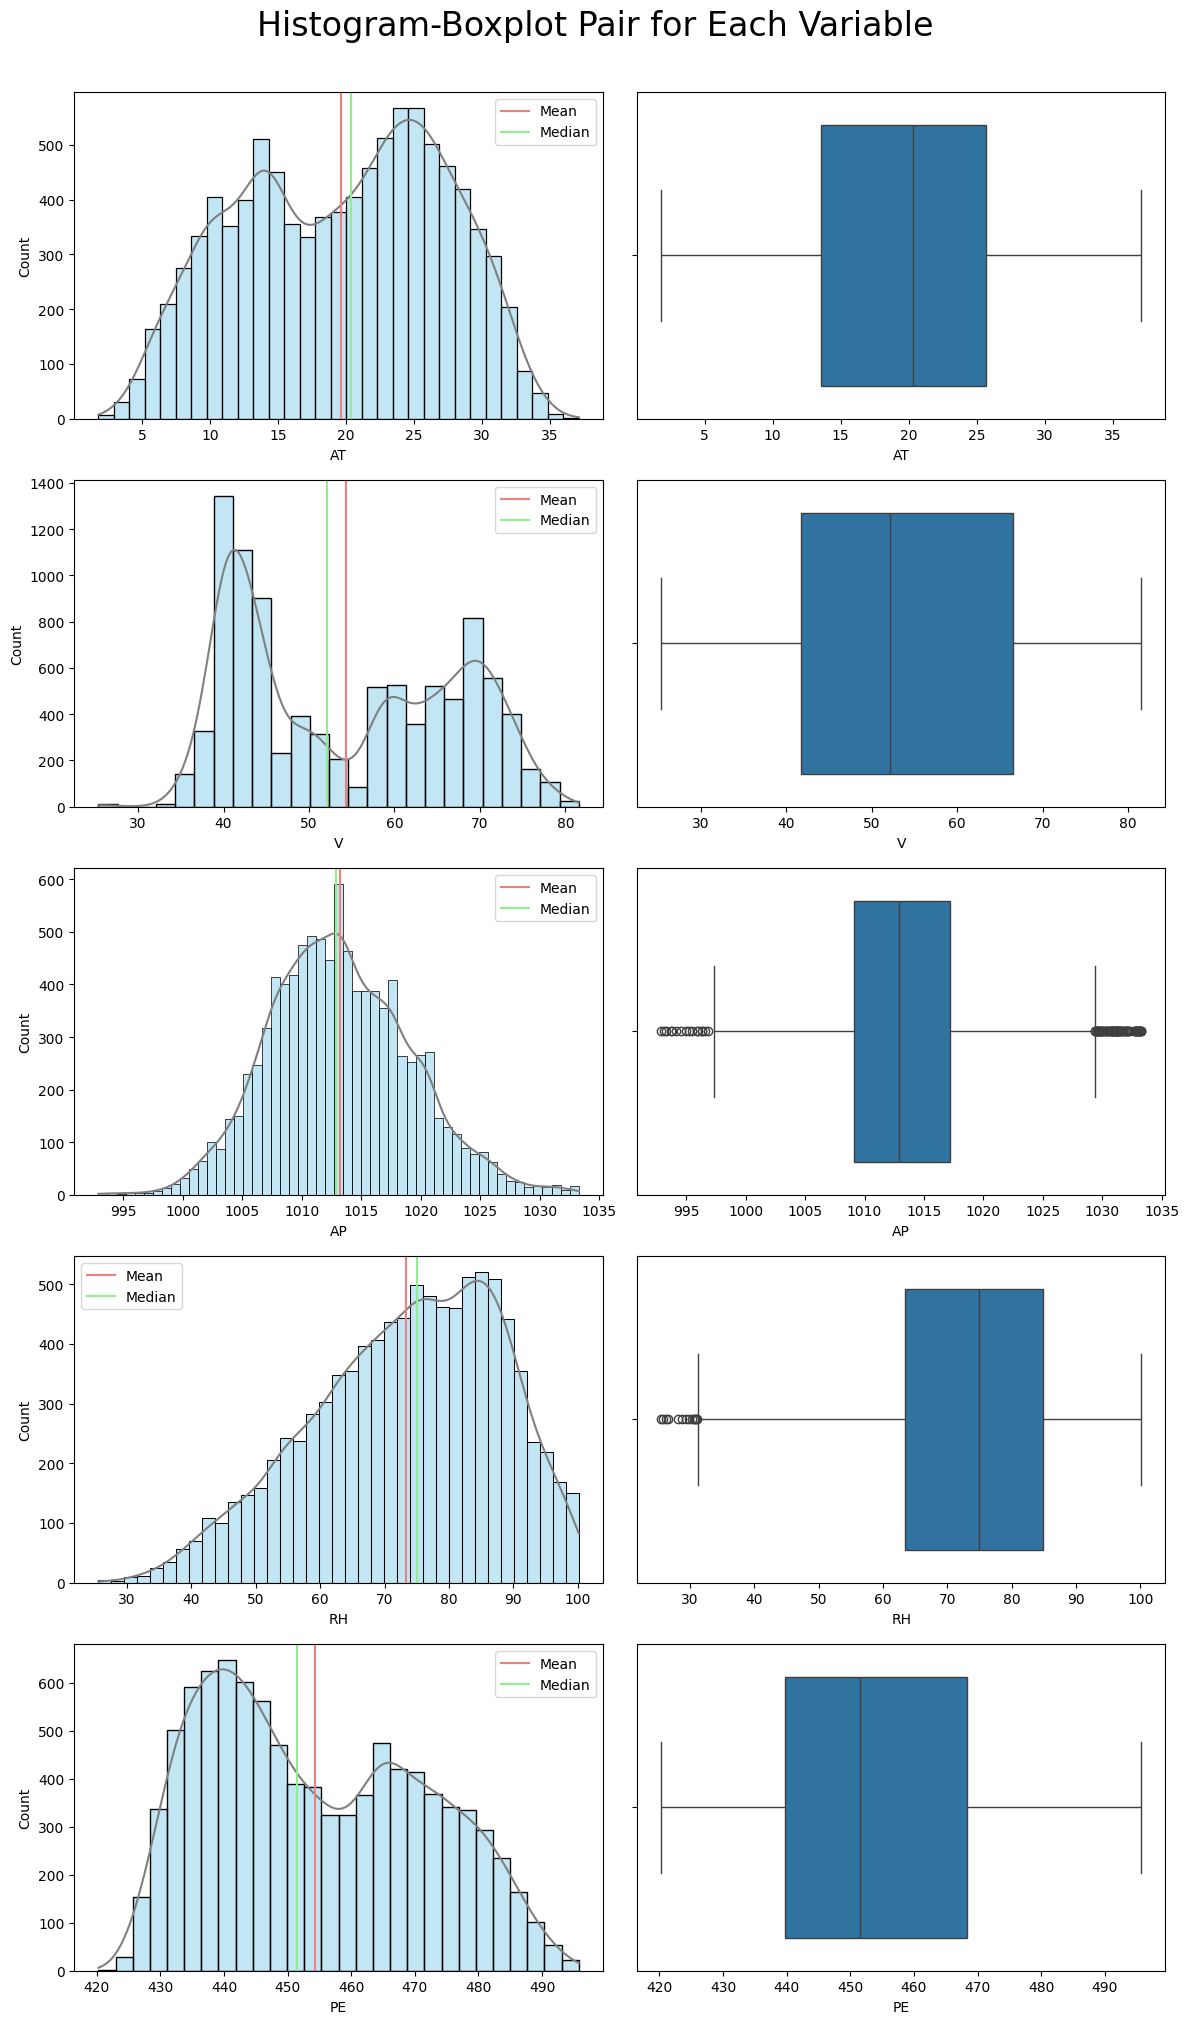

In [12]:
# Get column names
cols = df.columns

# Create a figure for plotting the histograms and boxplots of the 5 variables
plt.figure(figsize=(12, 20))

# Loop through the number of variables to create plots
for i, col in enumerate(cols):
    # Add histogram with kde curve and mean and median indicators
    plt.subplot(len(cols), 2, 2*i+1)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.axvline(x=df[col].mean(), color='lightcoral', label='Mean')
    plt.axvline(x=df[col].median(), color='lightgreen', label='Median')
    plt.legend()
    
    # Set the colour of KDE line to grey
    plt.gca().get_lines()[0].set_color('grey')

    # Add box plot
    plt.subplot(len(cols), 2, 2*i+2)
    sns.boxplot(x=df[col])

# Add title, tighten the layout and display the plot
plt.suptitle("Histogram-Boxplot Pair for Each Variable", fontsize=24, y=1.01)
plt.tight_layout()
plt.show()

#### Outliers

Analysis and visualization to understand the outliers

In [13]:
# Calculate Q1 and Q3 of AP
AP_Q1 = df['AP'].quantile(0.25)
AP_Q3 = df['AP'].quantile(0.75)

# Calculate the low and high outlier cutoff for AP
low_AP_outlier_cutoff = AP_Q1 - 1.5 * (AP_Q3 - AP_Q1)
high_AP_outlier_cutoff = AP_Q3 + 1.5 * (AP_Q3 - AP_Q1)

# Get the number of low and high outliers
num_low_AP = len(df[df['AP']<low_AP_outlier_cutoff])
num_high_AP = len(df[df['AP']>high_AP_outlier_cutoff])

print(f"There are {num_low_AP} low AP outliers and {num_high_AP} high AP outliers.")
print(f"They represent {num_low_AP/len(df)*100:.2f}% and {num_high_AP/len(df)*100:.2f}% of the total data points.")

There are 16 low AP outliers and 75 high AP outliers.
They represent 0.17% and 0.79% of the total data points.


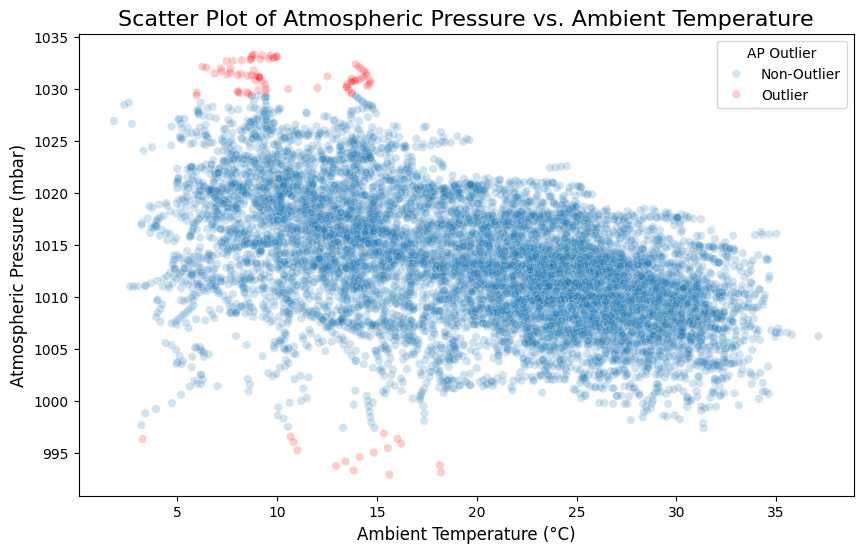

In [14]:
# Create a copy of df with AT and AP columns
df_AP = df[['AT', 'AP']].copy()

# Create a new column as an outlier indicator
df_AP['Outlier'] = 'Non-Outlier'
df_AP.loc[df_AP['AP']<low_AP_outlier_cutoff, 'Outlier'] = 'Outlier'
df_AP.loc[df_AP['AP']>high_AP_outlier_cutoff, 'Outlier'] = 'Outlier'

plt.figure(figsize=(10, 6))
# Assign different hues to the points based on the 'Outlier' column
sns.scatterplot(data=df_AP, x='AT', y='AP', hue='Outlier', palette=['#1f77b4', 'red'], alpha=0.2)

plt.xlabel('Ambient Temperature (°C)', size=12)
plt.ylabel('Atmospheric Pressure (mbar)', size=12)
plt.title('Scatter Plot of Atmospheric Pressure vs. Ambient Temperature', size=16)
plt.legend(title='AP Outlier')

plt.show()

In [15]:
# Calculate Q1 and Q3 of RH
RH_Q1 = df['RH'].quantile(0.25)
RH_Q3 = df['RH'].quantile(0.75)

# Calculate the lower outlier cutoff for RH
low_RH_outlier_cutoff = RH_Q1 - 1.5 * (RH_Q3 - RH_Q1)

# Get the number of low outliers
num_low_RH = len(df[df['RH']<low_RH_outlier_cutoff])

print(f"There are {num_low_RH} low RH outliers.")
print(f"They represent {num_low_RH/len(df)*100:.2f}% of the total data points.")

There are 13 low RH outliers.
They represent 0.14% of the total data points.


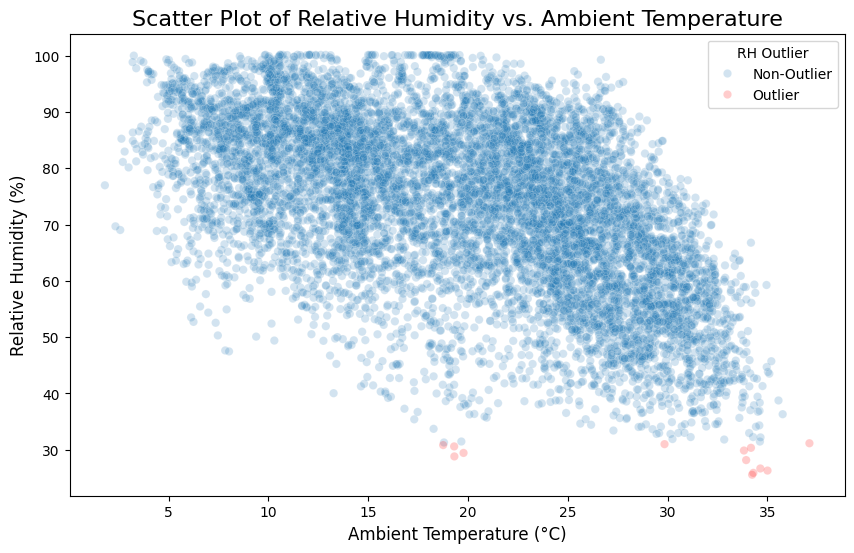

In [16]:
# Create a copy of df with AT and RH columns
df_RH = df[['AT', 'RH']].copy()

# Create a new column as an outlier indicator
df_RH['Outlier'] = 'Non-Outlier'
df_RH.loc[df_RH['RH']<low_RH_outlier_cutoff, 'Outlier'] = 'Outlier'

plt.figure(figsize=(10, 6))
# Assign different hues to the points based on the 'Outlier' column
sns.scatterplot(data=df_RH, x='AT', y='RH', hue='Outlier', palette=['#1f77b4', 'red'], alpha=0.2)

plt.xlabel('Ambient Temperature (°C)', size=12)
plt.ylabel('Relative Humidity (%)', size=12)
plt.title('Scatter Plot of Relative Humidity vs. Ambient Temperature', size=16)
plt.legend(title='RH Outlier')

plt.show()

The histograms show three variables having a bimodal distribution. They are AT, V and PE. The shape of PE is very much a reflection or lateral inversion of AT, further confirming the very high negative correlation between them, as surfaced in the correlation matrix. While the bimodal distribution of V corroborates with the positive correlation between AT and V indicated in the correlation matrix, the reason for its shape is not evident.

The AP histogram shows a distribution that is close to normal but the boxplot shows a number of outliers. The scatterplot of AT versus AP show both high and low AP outliers to be extensions of high and low AP values rather than isolated or disjointed groups of values. Additionally, the values are in the sane range so they will be kept for model training and testing.

There is an obvious skew to the left (or negative skewness) in the RH data, indicating moderate to high relative humidity much of the time, during the period the data was collected. This is consistent with the climate at geographical location of the power plant, Türkiye, which is straddled by the Black Sea to the north and the Aegean Sea and the Mediterranean Sea to the west and to the south. There were 13 outlier RH values but they were not separated or isolated from other low RH data points (as shown in the plot of AT versus RH) so they will be retained.

### Data Preparation and Feature Engineering

#### Data splitting

The dataset is split into training, validation and test sets in the ratios, 0.75, 0.125 and 0.125.

In [17]:
# Define the target variable
target_variable = "PE"

# Separate features and target
X = df.drop(target_variable, axis=1)
y = df[target_variable]

features = X.columns.values.tolist()

# Set the seed
random_state = 1

In [18]:
# Split data in the ratio 0.75 for training and 0.25 for validation and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=random_state
)

# Split the 25% evenly to create validation and test datasets
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=random_state
)

In [19]:
X_test

,AT,V,AP,RH
7353,15.20,39.00,1016.10,72.76
6973,24.02,70.94,1008.00,79.55
6153,23.24,68.31,1009.71,80.80
2659,27.09,65.61,1014.22,48.13
39,23.18,51.30,1012.04,78.64
...,...,...,...,...
8110,23.62,45.87,1007.75,58.69
5945,30.06,69.14,1007.50,72.48
5363,9.08,42.49,1010.67,85.35
2620,23.39,71.25,1005.22,93.70


In [20]:
# Check the shape of the train, validation and test datasets
print('Shape of train, validation and test datasets')
print('X_train     y_train')
print(f'{X_train.shape}   {y_train.shape}')
print()
print('X_val       y_val')
print(f'{X_val.shape}   {y_val.shape}')
print()
print('X_test      y_test')
print(f'{X_test.shape}   {y_test.shape}')

Shape of train, validation and test datasets
X_train     y_train
(7145, 4)   (7145,)

X_val       y_val
(1191, 4)   (1191,)

X_test      y_test
(1191, 4)   (1191,)


#### Save test data for use in during testing

In [21]:
# Combine X_test and y_test into one dataframe
test_data = pd.concat([X_test, y_test], axis=1)

# Save the test data for use in during testing
test_data_file = './test_data/test_data.csv'
test_data.to_csv(test_data_file, index=False)

print(f"Test data saved to '{test_data_file}'.")

Test data saved to './test_data/test_data.csv'.


#### Principal component analysis
To determine the number of principal components, the scree plot is used to visualize the proportion of variance explained by each component.

In [22]:
# Standardize the training data and perform PCA to get the proportion of 
# variance explained by each principal component
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=4)
pca.fit(X_train_scaled)

eigenvalues = pca.explained_variance_
prop_var = eigenvalues / sum(eigenvalues)


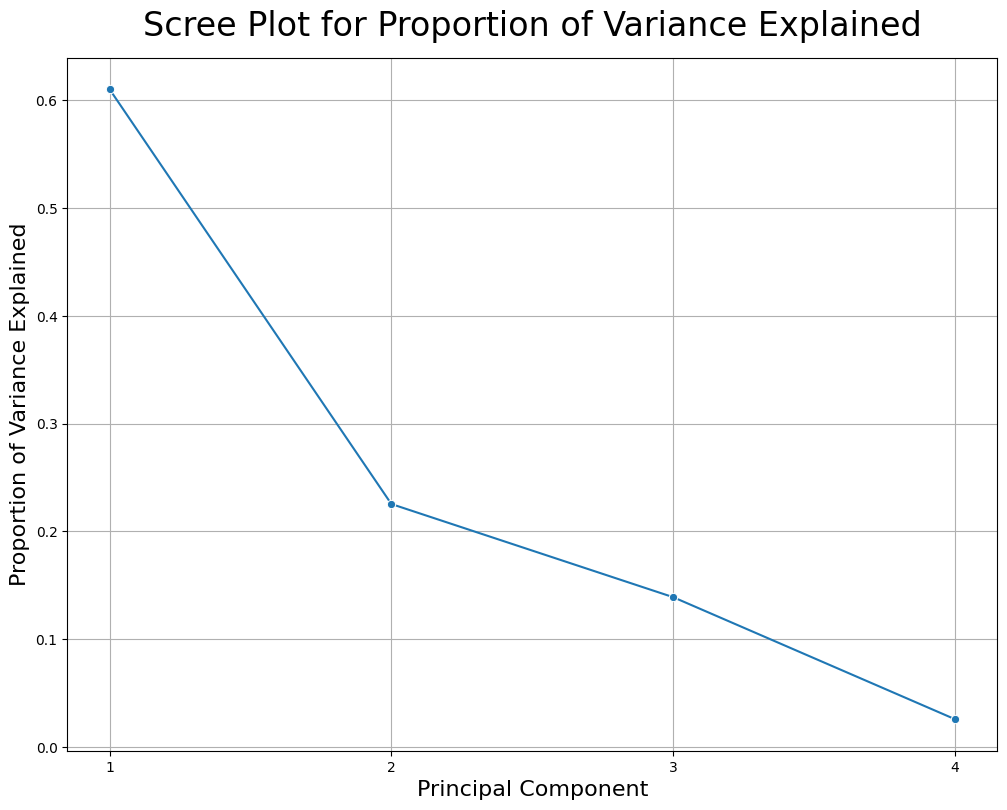

In [23]:
# Create the scree plot for proportion of variance explained
plt.figure(figsize=(12,9))
sns.lineplot(x=list(range(1,len(prop_var)+1)), y=prop_var, marker='o')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Principal Component',size = 16)
plt.ylabel('Proportion of Variance Explained',size = 16)
plt.title('Scree Plot for Proportion of Variance Explained',size = 24, y=1.02)
plt.grid(True)

In [24]:
# Calculate the sum of the proportion of variance explained by the first two
# principal components (as suggested by the shape of the scree plot)
print('Proportion of variance explained by each component')
print(dict(zip(list(range(1,len(prop_var)+1)), prop_var)))
print()
print(f'Together, the first two components explain {(prop_var[0] + prop_var[1]) * 100:.2f}% of the proportion of variance.')

Proportion of variance explained by each component
{1: 0.6100902846137117, 2: 0.22531930135296468, 3: 0.13889941492704916, 4: 0.025690999106274353}

Together, the first two components explain 83.54% of the proportion of variance.


The shape of the scree plot and the calculated sum of proportion of variance explained by the first two principal components suggest the `n_component` parameter of `PCA()` should be set to 2.

In [25]:
# Set the number of principal components for PCA
n_components = 2

### Model Training and Hyperparameter Tuning Setup

#### Base models
Three models will be created, one each from `RandomForestRegressor()`, `GradientBoostingRegressor()` and `SVR()`.

In [26]:
# Define the base models
rand_forest = RandomForestRegressor(random_state=random_state)
grad_boost = GradientBoostingRegressor(random_state=random_state)
supp_vector = SVR()

algorithms = [
    ("Support Vector", supp_vector),
    ("Random Forest", rand_forest),
    ("Gradient Boosting", grad_boost),
]

#### Hyperparameter tuning and model performance recording setup

The hyperparmeters to be tuned are first defined for each model. A dataframe is also created to act as temporary storage for the tuned models, and their hyperparameters and performance metrics.

In [27]:
# Define the hyperparameters to be tuned via grid search
param_grids = {
    "Support Vector": {
        "regressor__kernel": ["linear", "rbf", "sigmoid"],
        "regressor__C": [0.1, 1, 10, 20],
        "regressor__gamma": ["scale", "auto"],
        "regressor__epsilon": [0.01, 0.05, 0.1, 0.2]
    },
    "Random Forest": {
        "regressor__n_estimators": [100, 250, 500],
        "regressor__max_depth": [3, 5, 10, 20, None],
        "regressor__max_leaf_nodes": [10, 20, 50, None]
    },
    "Gradient Boosting": {
        "regressor__n_estimators": [100, 250, 500],
        "regressor__learning_rate": [0.05, 0.1, 0.2, 0.3],
        "regressor__max_depth": [5, 6, 7, None],
        "regressor__min_samples_leaf": [0.0001, 0.001, 0.01, 0.1]
    },
}

In [28]:
# Initialize a DataFrame to store model details and performance metrics
results = pd.DataFrame(
    columns=[
        "Regressor",
        "Tuned Hyperparameters",
        "Mean Squared Error",
        "Root Mean Squared Error",
        "R Squared",
        "Model",
    ]
)

### Model Training, Hyperparameter Tuning and Validation

#### Model training with cross-validated grid-search hyperparameter tuning

Model training is done with cross-validated grid search to get the best performance out of each base model. The best of each base model is added to the temporary model storage.

In [29]:
# Use MSE as for scoring during grid search
scoring_metric = "neg_mean_squared_error"

# Cycle through each algorithm and train a model
for algorithm_name, algorithm in algorithms:
    print(f"Algorithm: {algorithm_name}")
    print("―" * (10+len(algorithm_name)))
    
    # Define the steps in the pipeline, starting with scaling
    steps = [("scaler", StandardScaler())]
    
    # Get the relevant hyperparameters for the current algorithm
    param_grid = param_grids[algorithm_name].copy()
    
    if algorithm_name == "Support Vector": # Add PCA for non-tree algorithm
        steps.append(("pca", PCA(n_components=n_components)))
        
    # Finally, add the regressor
    steps.append(("regressor", algorithm))

    # Create the pipeline
    pipeline = Pipeline(steps)

    # Create the grid search with cross-validation for hyperparameter tuning
    gs = GridSearchCV(
        pipeline, param_grid, cv=5, scoring=scoring_metric, verbose=3, n_jobs=-1
    )

    # Train the model
    gs.fit(X_train, y_train)
    print()

    # Get the best model for the current algorithm
    best_model = gs.best_estimator_
    
    # Evaluate the current model using validation data
    y_pred = best_model.predict(X_val)

    # Add the best model for the current algorithm and its parameters and 
    # validation performance metrics to the results dataframe
    current_result = pd.DataFrame(
        [
            {
                "Regressor": algorithm_name,
                "Tuned Hyperparameters": gs.best_params_,
                "Mean Squared Error": mean_squared_error(y_val, y_pred),
                "Root Mean Squared Error": sqrt(mean_squared_error(y_val, y_pred)),
                "R Squared": r2_score(y_val, y_pred),
                "Model": best_model,
            }
        ]
    )

    results = pd.concat([results, current_result], ignore_index=True)

Algorithm: Support Vector
――――――――――――――――――――――――
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[CV 2/5] END regressor__C=0.1, regressor__epsilon=0.01, regressor__gamma=scale, regressor__kernel=linear;, score=-46.767 total time=   9.0s
[CV 1/5] END regressor__C=0.1, regressor__epsilon=0.01, regressor__gamma=scale, regressor__kernel=linear;, score=-44.822 total time=   8.5s
[CV 3/5] END regressor__C=0.1, regressor__epsilon=0.01, regressor__gamma=scale, regressor__kernel=linear;, score=-44.868 total time=   7.9s
[CV 5/5] END regressor__C=0.1, regressor__epsilon=0.01, regressor__gamma=scale, regressor__kernel=linear;, score=-45.665 total time=   7.7s
[CV 4/5] END regressor__C=0.1, regressor__epsilon=0.01, regressor__gamma=scale, regressor__kernel=linear;, score=-48.360 total time=   7.8s
[CV 2/5] END regressor__C=0.1, regressor__epsilon=0.01, regressor__gamma=scale, regressor__kernel=rbf;, score=-44.470 total time=  11.2s
[CV 1/5] END regressor__C=0.1, regressor__epsilon=0.01, regressor__gamma=scale, regressor__kernel=rbf;, score=-42.788 total time=  10.6s
[CV 3/5] END regressor__C=

/tmp/ipykernel_12514/2356058249.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, current_result], ignore_index=True)


Algorithm: Random Forest
―――――――――――――――――――――――
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 3/5] END regressor__max_depth=3, regressor__max_leaf_nodes=10, regressor__n_estimators=100;, score=-24.215 total time=   2.3s
[CV 2/5] END regressor__max_depth=3, regressor__max_leaf_nodes=10, regressor__n_estimators=100;, score=-23.289 total time=   2.6s
[CV 1/5] END regressor__max_depth=3, regressor__max_leaf_nodes=10, regressor__n_estimators=100;, score=-22.496 total time=   2.6s
[CV 5/5] END regressor__max_depth=3, regressor__max_leaf_nodes=10, regressor__n_estimators=100;, score=-23.600 total time=   2.6s
[CV 4/5] END regressor__max_depth=3, regressor__max_leaf_nodes=10, regressor__n_estimators=100;, score=-26.622 total time=   2.9s
[CV 3/5] END regressor__max_depth=3, regressor__max_leaf_nodes=10, regressor__n_estimators=250;, score=-24.208 total time=   6.0s
[CV 2/5] END regressor__max_depth=3, regressor__max_leaf_nodes=10, regressor__n_estimators=250;, score=-23.20

#### Performance reporting

In [30]:
# Display the results dataframe
results

,Regressor,Tuned Hyperparameters,Mean Squared Error,Root Mean Squared Error,R Squared,Model
0,Support Vector,"{'regressor__C': 20, 'regressor__epsilon': 0.1...",36.406604,6.033789,0.873547,"(StandardScaler(), PCA(n_components=2), SVR(C=..."
1,Random Forest,"{'regressor__max_depth': 20, 'regressor__max_l...",11.028530,3.320923,0.961694,"(StandardScaler(), (DecisionTreeRegressor(max_..."
2,Gradient Boosting,"{'regressor__learning_rate': 0.2, 'regressor__...",9.490865,3.080725,0.967035,"(StandardScaler(), ([DecisionTreeRegressor(cri..."


In [31]:
# Display the model details and performance metrics for each algorithm
print("Model performance on validation data")
print("―" * 36)
for i in range(len(results)):
    print(f"Algorithm: {results.loc[i, 'Regressor']}")
    params = results.loc[i, "Tuned Hyperparameters"]
    for k, v in params.items():
        print(f'{k}: {v}')
    print(f"MSE: {results.loc[i, 'Mean Squared Error']}")
    print(f"RMSE: {results.loc[i, 'Root Mean Squared Error']}")
    print(f"R2: {results.loc[i, 'R Squared']}")
    print()

Model performance on validation data
――――――――――――――――――――――――――――――――――――
Algorithm: Support Vector
regressor__C: 20
regressor__epsilon: 0.1
regressor__gamma: auto
regressor__kernel: rbf
MSE: 36.40660409479794
RMSE: 6.033788535803848
R2: 0.873546600196508

Algorithm: Random Forest
regressor__max_depth: 20
regressor__max_leaf_nodes: None
regressor__n_estimators: 500
MSE: 11.028530216002787
RMSE: 3.3209230969721033
R2: 0.9616938966068422

Algorithm: Gradient Boosting
regressor__learning_rate: 0.2
regressor__max_depth: 6
regressor__min_samples_leaf: 0.0001
regressor__n_estimators: 500
MSE: 9.490864624171994
RMSE: 3.080724691395191
R2: 0.9670347694150159



### Model Selection

#### Best performing model

Of the three base models, the one with the lowest mean squared error is the best performing one and it will be the one the final model is based on.

In [32]:
# Display the best model (based on MSE)
lowest_MSE = min(results['Mean Squared Error'])
selected_model = results[results['Mean Squared Error']==lowest_MSE]['Model'].iloc[0]
print("Best performing model")
print("―" * 21)
print(selected_model)

Best performing model
―――――――――――――――――――――
Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.2, max_depth=6,
                                           min_samples_leaf=0.0001,
                                           n_estimators=500, random_state=1))])


In [33]:
# Sort results dataframe by MSE to select the best model
sorted_results = results.sort_values(by='Mean Squared Error')

In [34]:
# Displayed the sorted results dataframe
sorted_results

,Regressor,Tuned Hyperparameters,Mean Squared Error,Root Mean Squared Error,R Squared,Model
2,Gradient Boosting,"{'regressor__learning_rate': 0.2, 'regressor__...",9.490865,3.080725,0.967035,"(StandardScaler(), ([DecisionTreeRegressor(cri..."
1,Random Forest,"{'regressor__max_depth': 20, 'regressor__max_l...",11.028530,3.320923,0.961694,"(StandardScaler(), (DecisionTreeRegressor(max_..."
0,Support Vector,"{'regressor__C': 20, 'regressor__epsilon': 0.1...",36.406604,6.033789,0.873547,"(StandardScaler(), PCA(n_components=2), SVR(C=..."


#### Saving the best performing base model and its details

In [35]:
# Save the best performing model for subsequent use
top_result_file = './experimentation_result/top_result.pkl'
with open(top_result_file, 'wb') as f:
    pickle.dump(sorted_results.iloc[0], f)

### Final Model Training Using Combined Data (Train and Validation)

#### Data preparation

The training and validation datasets are combined to train the final model.

In [36]:
# Concatenate the training and validation datasets to form the final dataset
# used to train the final model
X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])

In [37]:
# Check the shape of the full train and test datasets
print("Shape of full train and test datasets")
print("X_full_train    y_full_train")
print(f"{X_full_train.shape}       {y_full_train.shape}")
print()
print("X_test          y_test")
print(f"{X_test.shape}       {y_test.shape}")

Shape of full train and test datasets
X_full_train    y_full_train
(8336, 4)       (8336,)

X_test          y_test
(1191, 4)       (1191,)


#### Loading hyperparameters from the best performing model

The final model will be based on the best base model saved previously.

In [38]:
# Load the best model stored in the top_result file
top_result_file = './experimentation_result/top_result.pkl'
with open(top_result_file, "rb") as f:
    top_result = pickle.load(f)

print(f"Success loading '{top_result_file}'.")
print()

# Get details of the model
algorithm_name = top_result["Regressor"]
params = top_result["Model"].get_params()

Success loading './experimentation_result/top_result.pkl'.



#### Final model pipeline setup and training

In [39]:
# Define the pipeline based on the selected model
steps = [("scaler", params['scaler'])]
if algorithm_name == "Support Vector": # Add PCA for non-tree algorithm
    steps.append(("pca", params['pca']))
steps.append(("regressor", params['regressor']))

final_pipeline = Pipeline(steps)

print("Training final model...")
final_model = final_pipeline.fit(X_full_train, y_full_train)

# Get the final model
final_model

Training final model...


Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.2, max_depth=6,
                                           min_samples_leaf=0.0001,
                                           n_estimators=500, random_state=1))])

### Final Model Evaluation Using Test Data

In [40]:
# Evaluate the current model using test data
y_pred = final_model.predict(X_test)

# Display model details and performance metrics from test data
print("Model performance on test data")
print("―" * 30)
print(f"Algorithm: {algorithm_name}")
for k, v in final_model.get_params()['regressor'].get_params().items():
    print(f'{k}: {v}')
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R2: {r2_score(y_test, y_pred)}")

Model performance on test data
――――――――――――――――――――――――――――――
Algorithm: Gradient Boosting
alpha: 0.9
ccp_alpha: 0.0
criterion: friedman_mse
init: None
learning_rate: 0.2
loss: squared_error
max_depth: 6
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 0.0001
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 500
n_iter_no_change: None
random_state: 1
subsample: 1.0
tol: 0.0001
validation_fraction: 0.1
verbose: 0
warm_start: False
MSE: 8.004013588640985
RMSE: 2.8291365447148333
R2: 0.9731431073160591


The final model performed very well on the test dataset. This is to be expected given the best base model's good prediction performance on the validation dataset and the fact that model was the template for the final model, and both training and validation datasets were used to train it.

### Save Final Model

In [41]:
# Save the final model for use in production
final_model_file = './model/ccpp_model.pkl'
with open(final_model_file, 'wb') as f:
    pickle.dump(final_model, f)

print(f"Final model saved to '{final_model_file}'.")

Final model saved to './model/ccpp_model.pkl'.
